# Introduction: Titanic Survivals Classifier
_Author: Beatriz Golindano_

### Content

1. Loading and initial visualization of the train an test datasets.
2. Feature Engineering.
3. Data Cleaning.
4. Data visualization for models.
5. Features Correlation: Pearson Correlation.
6. Features Correlation: Pairplots.
7. Esembling and Stacking Models.
8. Generating First - Level Models.
9. Second - Level Predicions from the First - Level Output.
10. Producing the Submission file.

In [2]:
#Import the libraries

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

#Importing 5 base models for stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
#from sklearn.cross_validation import KFold

In [3]:
#Checking if the libraries are installed: For beginners
#It only works when you import a complete library

print(np.__version__)
print(sns.__version__)
print(xgb.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(re.__version__)

1.15.4
0.9.0
0.90
0.9.0
0.20.1
2.2.1


## 1. Loading and initial visualization of the train and test datasets

Apart from importing libraries, we must import the data that will be processed for the models creation. In this case, a csv reader with 'Float64' is used where appropriate, within python, this data type is much more accurate. 

First, the information collected from 'train.csv' and 'test.csv' is displayed, then, the data of both sets are shown (5 rows by default).

In [4]:
#Loading the train and test datasets
train = pd.read_csv('/home/patria/Documentos/ANALISIS DEL NEGOCIO/Data Science Project 1: Titanic/train.csv', header = 0,
dtype = {'Age':np.float64})
test = pd.read_csv('/home/patria/Documentos/ANALISIS DEL NEGOCIO/Data Science Project 1: Titanic/test.csv', header = 0,
dtype = {'Age':np.float64})
full_data = [train,test]

#Printing train dataset information
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [5]:
#Printing test dataset information
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [6]:
#Showing test dataset (only 5 rows)
PassengerId = test['PassengerId']
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2. Feature Engineering

After obtaining the data, we proceed to explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

Some of the variables that are evaluated for the treatment are the following:

### - SibSp and Parch
With the number of siblings/spouse and the number of children/parents we can create new feature called 'Family Size'.
### - Embarked
the embarked feature has some missing value and we try to fill those with the most occurred value 'S'.
### - Fare
Fare also has some missing value and we will replace it with the median, then, we categorize it into 4 ranges (Data Cleaning).
### - Age
We have plenty of missing values in this feature, we generate random numbers between (mean - std) and (mean + std), then, we categorize age into 5 range (Data Cleaning).
### - Name
Inside this feature we can find the title of people.
### - Title
We have titles. Let's categorize it and check the title impact on survival rate.

In [7]:
#Feature: Showing the length of the name (Train and test dataset)
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

In [8]:
#Feature to indicate if a titanic passenger had a cabin (Train and test dataset)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [9]:
#Feature Engineering (Apply to full_data): Create a new FamilySize as a combination of "SibSp" and "Parch"
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [10]:
#Feature Engineering (Apply to full_data): Create new feature 'IsAlone' from 'FamilySize'
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [11]:
#Feature Engineering (Apply to full_data): Remove all NULLS in the Embarked Column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [12]:
#Feature Engineering (Apply to full_data): Remove all Nulls in the 'Fare' column and create new feature 'CategoricalFare'
for dataset in full_data:
    dataset['Fare'] = dataset ['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [13]:
#Feature Engineering (Apply to full_data): Createw a new feature 'CategoricalAge'
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [14]:
#Feature Engineering (Apply to full_data): Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the tittle exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [15]:
#Feature Engineering (Apply to full_data): Create a new feature title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [16]:
#Feature Engineering (Apply to full_data): Gruop all non-common titles one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] =dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

 ## 3. Data Cleaning
 
Now, we proceed to the cleaning of the data, in order to extract relevant information, create ranges for the ordering of the data and discard the categorical columns. The functions must be numeric, with a suitable format to include in our models of Machine Learning.

In [17]:
#Mapping features (Clean full_data)
for dataset in full_data:
    #Mapping sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    #Mapping titles
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    #Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2}).astype(int)
    
    #Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [18]:
#Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

## 4. Data Visualization for models

The '.head()' method is invoked again to visualize the treated datasets.

In [19]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


## 5. Features Correlation: Pearson Correlation

You can generate some correlation graphs of the characteristics to see what relationship there is between one featrure and the next. For this, the Seaborn tracing package was used, which allows us to map heat maps in the most convenient way.

One thing that the Pearson correlation graph can tell us is that there are not too many features strongly correlated with each other. It is satisfactory for the inclusion of the characteristics in a learning model, because it means that there are not many redundant or superfluous data in our training set, that is, each feature carries with it some unique information. Here are two more correlated features that are the size of the family and Parch (Parents and children).

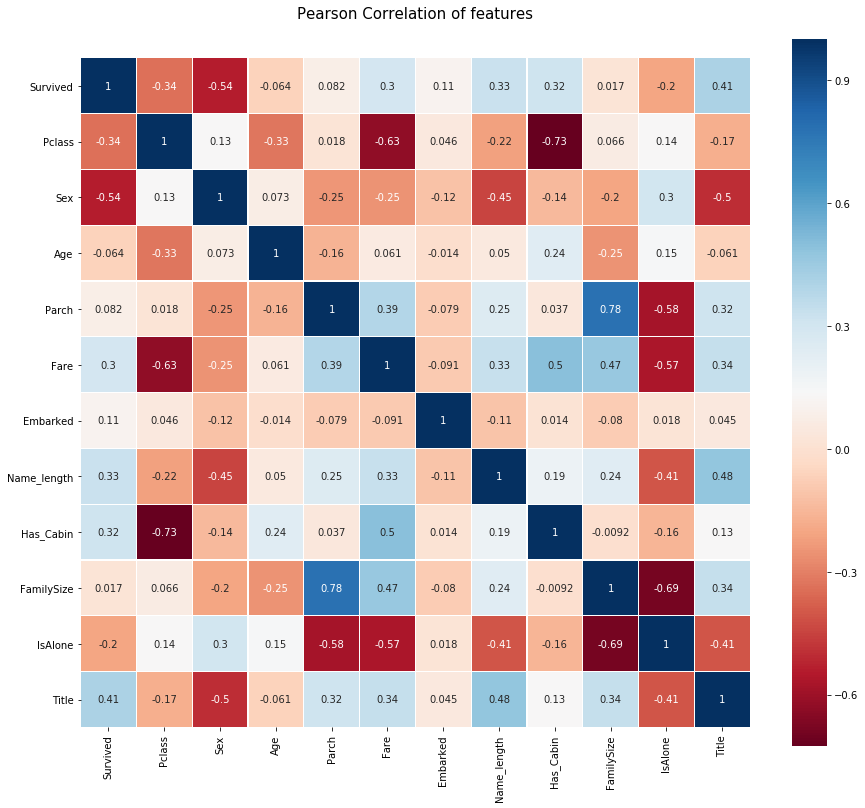

In [20]:
#Pearson correlation of features
colormap = plt.cm.RdBu
plt.figure(figsize = (15,13))
plt.title('Pearson Correlation of features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidth = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = 'white', annot = True)

### Note: Other Example (Pearson Correlation)

We've already seen a Pearson correlation scheme where most of its variables don't coincide. Now, What would happen in a case where there are many coincidences?. 

Taking as reference another dataset where the second case applies, let's say that heat maps make the difference between one case or another, for coincidences its tendency is marked by warm colors and otherwise, the trend is towards cold colors.

<img src="pearson_correlation.png">

## 6. Features Correlation: Pairplots

Finally, some pairsplots are shown to observe the data distribution from one feature to another. Once again we use Seaborn.

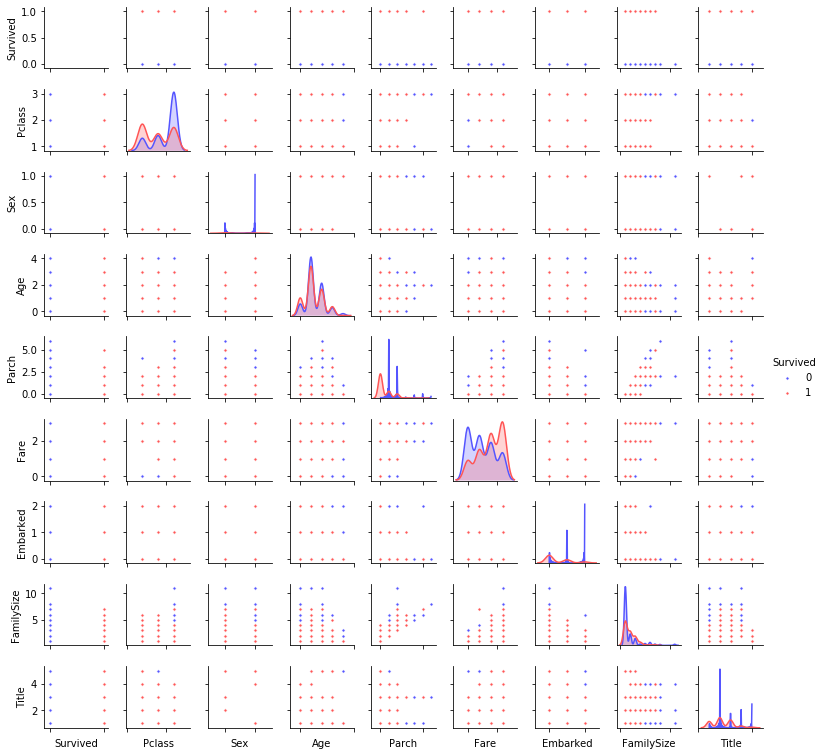

In [21]:
#Pairplots with Seaborn
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                       u'FamilySize', u'Title']], hue = 'Survived', palette = 'seismic', size = 1.2, diag_kind = 'kde', diag_kws = dict(shade = True), plot_kws = dict(s = 10))
g.set(xticklabels=[])

## 7. Esembling and Stacking Models

A stack set is created through Python classes. This allows to expand methods such as: train, fit, predict, among others; in the classifiers. In order to avoid their redundancy. For this, SklearnHelper is used.

In [22]:
#Some parameters

ntrain = train.shape[0]
ntest = test.shape[0]
#Set folds for out-of-fold prediction
NFOLDS = 5
SEED = 0
kf = KFold(n_splits = NFOLDS, shuffle = False, random_state = SEED)

#Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

### Out-of-fold Predictions

Stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training.

In [23]:
#OUT-OF-FOLD PREDICTIONS
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## 8. Generating First - Level Models

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

* Random Forest classifier.
* Extra Trees classifier.
* AdaBoost classifer.
* Gradient Boosting classifer.
* Support Vector Machine.
* Parameters.

For more information, read the [SkLearn Library Documentation](https://scikit-learn.org)

In [24]:
#Put in our parameters for said classifiers
#Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

#Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

#AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

#Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

#Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [25]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of train and test sets

Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes.

In [26]:
#Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values #Creates an array of the train data
x_test = test.values #Creates an array of the test data

### Output: First - Level Predictions

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions.

In [27]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances.

In [28]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12613785 0.20259406 0.03167674 0.02106394 0.07159568 0.02426818
 0.10720036 0.06595393 0.06596363 0.01335679 0.27018885]
[0.12082164 0.37964806 0.03046367 0.01654135 0.05553273 0.02781634
 0.04551153 0.08399388 0.04453472 0.02127954 0.17385656]
[0.034 0.01  0.016 0.068 0.038 0.01  0.694 0.014 0.052 0.    0.064]
[0.08400821 0.01073    0.05281814 0.01237762 0.05388621 0.02413471
 0.18002422 0.03866785 0.1091117  0.00616732 0.42807403]


In [29]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [30]:
cols = train.columns.values
#Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Interactive feature importances

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:

In [43]:
#Scatter plot 1
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

#Scatter plot 2
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 3
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

#Scatter plot 4
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [32]:
#Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) #axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


### Plotly Barplot of Average Feature Importances

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [41]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= True
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## 9. Second - Level Predicions from the First - Level Output

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [34]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation heatmap of the second level training set

In [40]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = False
    )
]
py.iplot(data, filename='labelled-heatmap')

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

In [36]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

### Second - Level Model: XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. We call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [37]:
gbm = xgb.XGBClassifier(
#learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

## 10. Producing the Submission file

Finally having trained and fit all our first-level and second-level models, we can now output the predictions.

In [38]:
#Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [39]:
StackingSubmission.head(418)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
